In [33]:
import numpy as np
import pandas as pd
from spec_id import Median_w_Error_cont, Gauss_dist, Stack_posteriors, Gen_grid,Iterative_stacking
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d
import seaborn as sea
from statsmodels.nonparametric.smoothers_lowess import lowess
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
from time import time
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
ksmooth = importr('KernSmooth')
# IDW =z_g.argsort()
# eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
# rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
# rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

In [ ]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [51]:
def Gauss_dist(x, mu, sigma):
    G = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    C = np.trapz(G, x)
    G /= C
    return G

def Lognormal_dist(x, mu, sigma):
    G = (1 / (x*sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
    C = np.trapz(G, x)
    G /= C
    return G

In [211]:
x=np.arange(.001,300,1)
lx=np.logspace(-4,2.1,300)
ers = np.arange(0,1.5,0.001)
gdist = Gauss_dist(x,3,.75)
lndist = Lognormal_dist(lx,3,.75)
sp_size = 12
s = np.random.lognormal(3, .75, 5000)

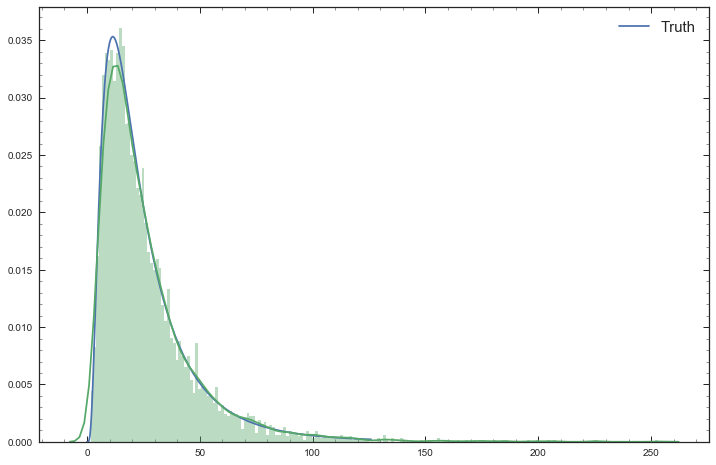

In [213]:
%matplotlib inline
plt.figure(figsize=[12,8])
# plt.plot(x,gdist,label='Truth')
plt.plot(lx,lndist,label='Truth')
sea.distplot(s,bins=200)
plt.legend(fontsize=15)

In [104]:
dist_grid= np.zeros([sp_size,x.size])
for i in range(sp_size):
    dist_grid[i] = Gauss_dist(x,np.random.normal(3,.75),np.random.choice(ers))

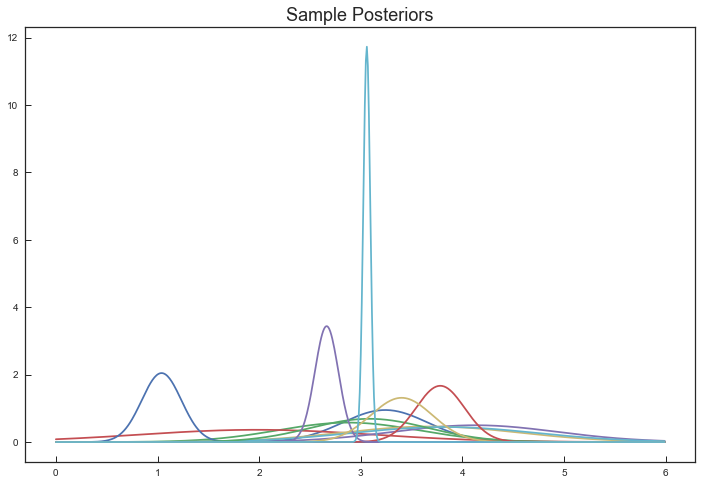

In [524]:
plt.figure(figsize=[12,8])
for i in range(sp_size):
    plt.plot(x,dist_grid[i])
plt.title('Sample Posteriors', fontsize =18)

In [525]:
def Iterate_stack(grid_o,x_o,its):
    del_x = x_o[1] - x_o[0]
    x_ext = np.append(np.append(x_o[0] - del_x,x_o),x_o[-1] + del_x)
    
    grid_ext = np.zeros([len(grid_o),x_ext.size])
    
    for i in range(len(grid_o)):
        grid_ext[i] = np.append(np.append(0,grid_o[i]),0)
    
    x = np.linspace(x_o[0],x_o[-1],1000)
    grid = np.zeros([len(grid_o),x.size])
        
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_ext,grid_ext[i])(x)
    
    
    sumpos = np.array(sum(grid)/np.trapz(sum(grid),x))
    Fx = np.ones(sumpos.size)
    for i in range(its):
        fnew = Fx * sumpos / np.trapz(Fx * sumpos,x)
        Fx = UnivariateSpline(x,fnew,k=4)(x)
        Fx[Fx<0]=0
    return Fx,x


def Iterate_stack_4(grid_o,x_o,its):
#     del_x = x_o[1] - x_o[0]
#     print del_x
#     x_ext = np.append(np.append(x_o[0] - del_x,x_o),x_o[-1] + del_x)
    
#     grid_ext = np.zeros([len(grid_o),x_ext.size])
    
#     for i in range(len(grid_o)):
#         grid_ext[i] = np.append(np.append(0,grid_o[i]),0)
    
    x = np.linspace(x_o[0],x_o[-1],1000)
    grid = np.zeros([len(grid_o),x.size])
        
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_o,grid_o[i])(x)
   
    H = ksmooth.dpik(x)
    stkpos = Stack_posteriors(grid,x)
    Fx = np.ones(stkpos.size)
    for i in range(its):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)
    Fx[Fx<0]=0
    Fx = Fx/np.trapz(Fx,x)
    return Fx,x

In [526]:
Pos = Stack_posteriors(dist_grid,x)
iterpos,iterx = Iterate_stack(dist_grid,x,20)
iterpos4,iterx4= Iterative_stacking(dist_grid,x,resampling=600)

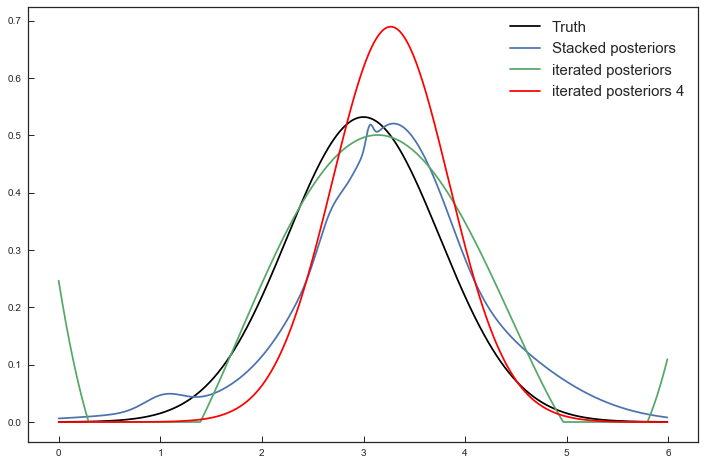

In [527]:
plt.figure(figsize=[12,8])
plt.plot(x,gdist,'k',label = 'Truth')
plt.plot(x,Pos,label = 'Stacked posteriors')
plt.plot(iterx,iterpos,label = 'iterated posteriors')
plt.plot(iterx4,iterpos4,'r',label = 'iterated posteriors 4')

plt.legend(fontsize = 15)

In [504]:
lzgrid = Gen_grid(lzDB,'Z')

In [531]:
X=metal

Pos = Stack_posteriors(lzgrid,X)
iterpos,iterx = Iterate_stack(lzgrid,X,20)
iterpos4,iterx4 = Iterative_stacking(lzgrid,X,resampling=500)


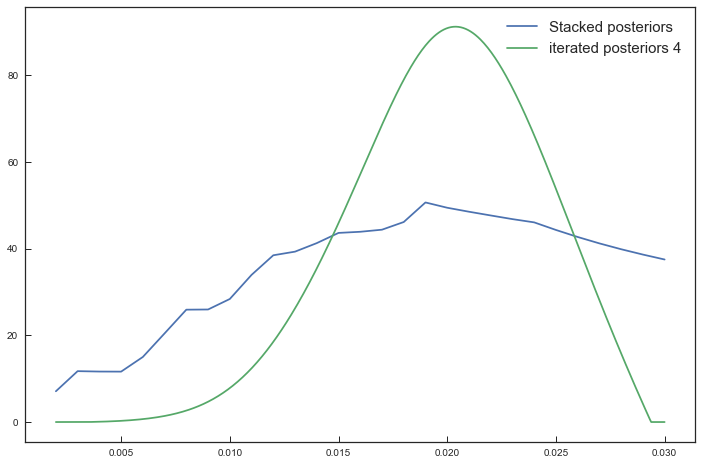

In [534]:
plt.figure(figsize=[12,8])
plt.plot(X,Pos,label = 'Stacked posteriors')
# plt.plot(iterx,iterpos,label = 'iterated posteriors')
plt.plot(iterx4,iterpos4,label = 'iterated posteriors 4')

plt.legend(fontsize = 15)

In [340]:
np.var(age)

2.6124999999999994

In [226]:
def Iterative_stacking(grid_o,x_o,LOG = False,iterations = 20,resampling = 1000):
    del_x = x_o[1] - x_o[0]

    ### resample
    if LOG == False:
        x = np.linspace(x_o[0],x_o[-1],resampling)
    else:
        x = np.logspace(np.log10(x_o[0]),np.log10(x_o[-1]),resampling)
        
    print x
    grid = np.zeros([len(grid_o),x.size])    
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_o,grid_o[i])(x)
   
    ### select bandwidth
    H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    Fx = Fx/np.trapz(Fx,x)
    return Fx,x

# Lognormal plot

In [223]:
dist_grid= np.zeros([sp_size,lx.size])
for i in range(sp_size):
    dist_grid[i] = Lognormal_dist(lx,np.random.normal(3,.75),np.random.choice(ers))

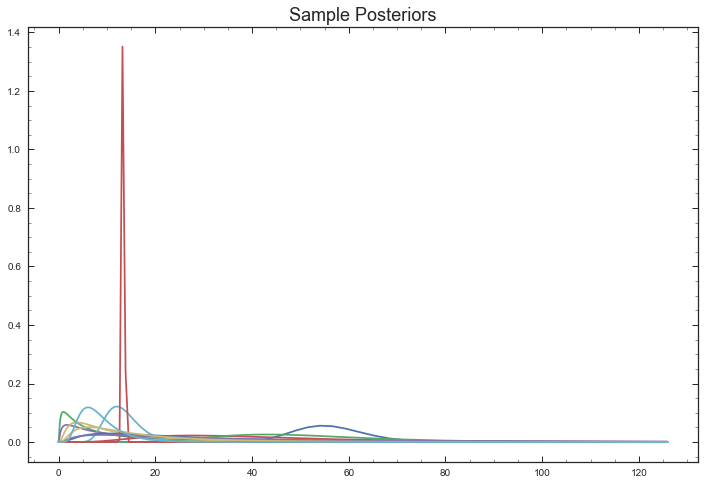

In [224]:
plt.figure(figsize=[12,8])
for i in range(sp_size):
    plt.plot(lx,dist_grid[i])
plt.title('Sample Posteriors', fontsize =18)

In [228]:
Pos = Stack_posteriors(dist_grid,lx)
iterpos,iterx = Iterate_stack(dist_grid,lx,20)
iterpos4,iterx4= Iterative_stacking(dist_grid,lx,LOG=True,iterations=1,resampling=250)

[  1.00000000e-04   1.05803002e-04   1.11942753e-04   1.18438794e-04
   1.25311800e-04   1.32583647e-04   1.40277479e-04   1.48417784e-04
   1.57030472e-04   1.66142954e-04   1.75784234e-04   1.85984997e-04
   1.96777711e-04   2.08196726e-04   2.20278387e-04   2.33061147e-04
   2.46585691e-04   2.60895065e-04   2.76034811e-04   2.92053118e-04
   3.09000968e-04   3.26932301e-04   3.45904190e-04   3.65977019e-04
   3.87214674e-04   4.09684751e-04   4.33458767e-04   4.58612390e-04
   4.85225678e-04   5.13383335e-04   5.43174982e-04   5.74695440e-04
   6.08045030e-04   6.43329898e-04   6.80662347e-04   7.20161199e-04
   7.61952171e-04   8.06168274e-04   8.52950238e-04   9.02446961e-04
   9.54815980e-04   1.01022397e-03   1.06884730e-03   1.13087253e-03
   1.19649709e-03   1.26592984e-03   1.33939178e-03   1.41711672e-03
   1.49935204e-03   1.58635947e-03   1.67841595e-03   1.77581447e-03
   1.87886503e-03   1.98789561e-03   2.10325324e-03   2.22530507e-03
   2.35443958e-03   2.49106777e-03

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


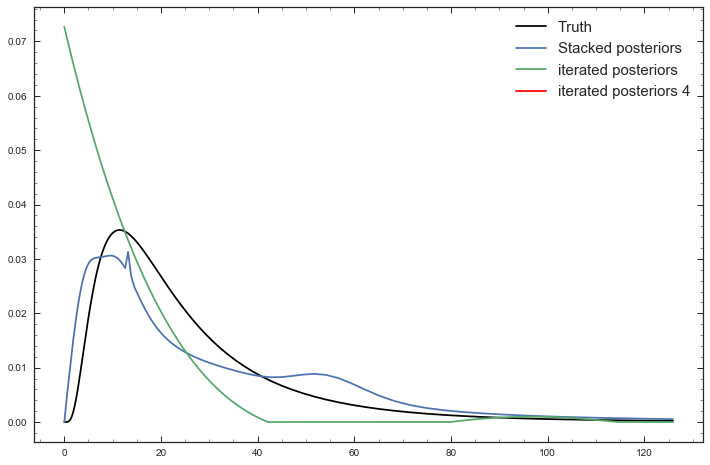

In [229]:
plt.figure(figsize=[12,8])
plt.plot(lx,lndist,'k',label = 'Truth')
plt.plot(lx,Pos,label = 'Stacked posteriors')
plt.plot(iterx,iterpos,label = 'iterated posteriors')
plt.plot(iterx4,iterpos4,'r',label = 'iterated posteriors 4')

plt.legend(fontsize = 15)

In [177]:
def Iterative_stacking(grid_o,x_o,LOG = False,iterations = 20,resampling = 1000):
    del_x = x_o[1] - x_o[0]

    ### resample
    if LOG == False:
        x = np.linspace(x_o[0],x_o[-1],resampling)
    else:
        x = np.logspace(np.log10(x_o[0]),np.log10(x_o[-1]),resampling)
        
    grid = np.zeros([len(grid_o),x.size])    
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_o,grid_o[i])(x)
   
    ### select bandwidth
    H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    Fx = Fx/np.trapz(Fx,x)
    return Fx,x

299999

# Binomial Distribution

In [36]:
x = np.linspace(0,10,100)

d1 = Gauss_dist(x,2,0.5)
d1 /= np.trapz(d1,x)
d2 = Gauss_dist(x,7,0.5)
d1 /= np.trapz(d2,x)

d3 = d1 + d2
d3 /= np.trapz(d3,x)

In [23]:
def Bimod_choice(mu1,sig1,mu2,sig2, X, size):
    Y = np.zeros(size)
    
    w = 0
    
    while w < size:
        test = np.random.rand()
        if test > 0.5:
            Y[w] = np.random.normal(mu1,sig1)
        else:
            Y[w] = np.random.normal(mu2,sig2)
            
        w+=1
        
    return Y

In [37]:
pts = Bimod_choice(2,0.5,7,0.5,x,1000)

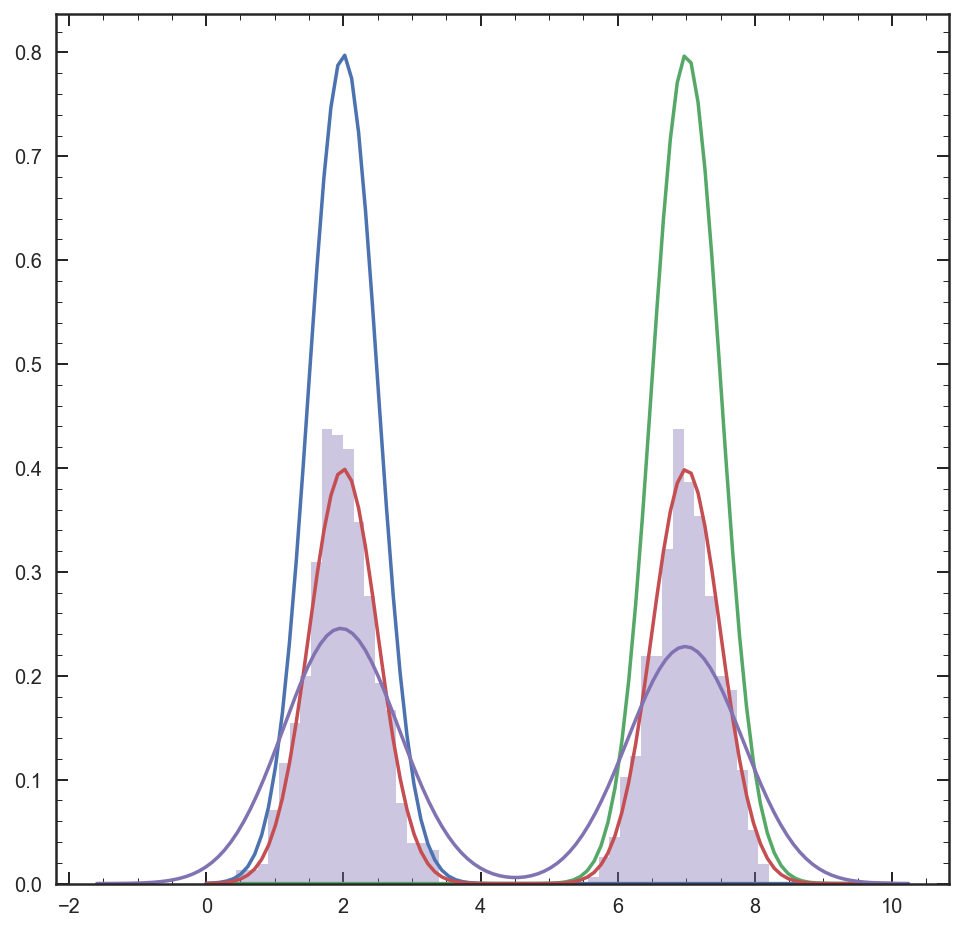

In [38]:
plt.figure(figsize=[8,8])
plt.plot(x,d1)
plt.plot(x,d2)
plt.plot(x,d3)
sea.distplot(pts,bins= 50)

In [71]:
sp_size=100
ers = np.arange(0,1,0.001)

dist_grid= np.zeros([sp_size,x.size])
for i in range(sp_size):
    test = np.random.rand()
    if test > 0.5:
        dist_grid[i] = Gauss_dist(x,np.random.normal(2,.5),np.random.choice(ers))
    else:
        dist_grid[i] = Gauss_dist(x,np.random.normal(7,.5),np.random.choice(ers))

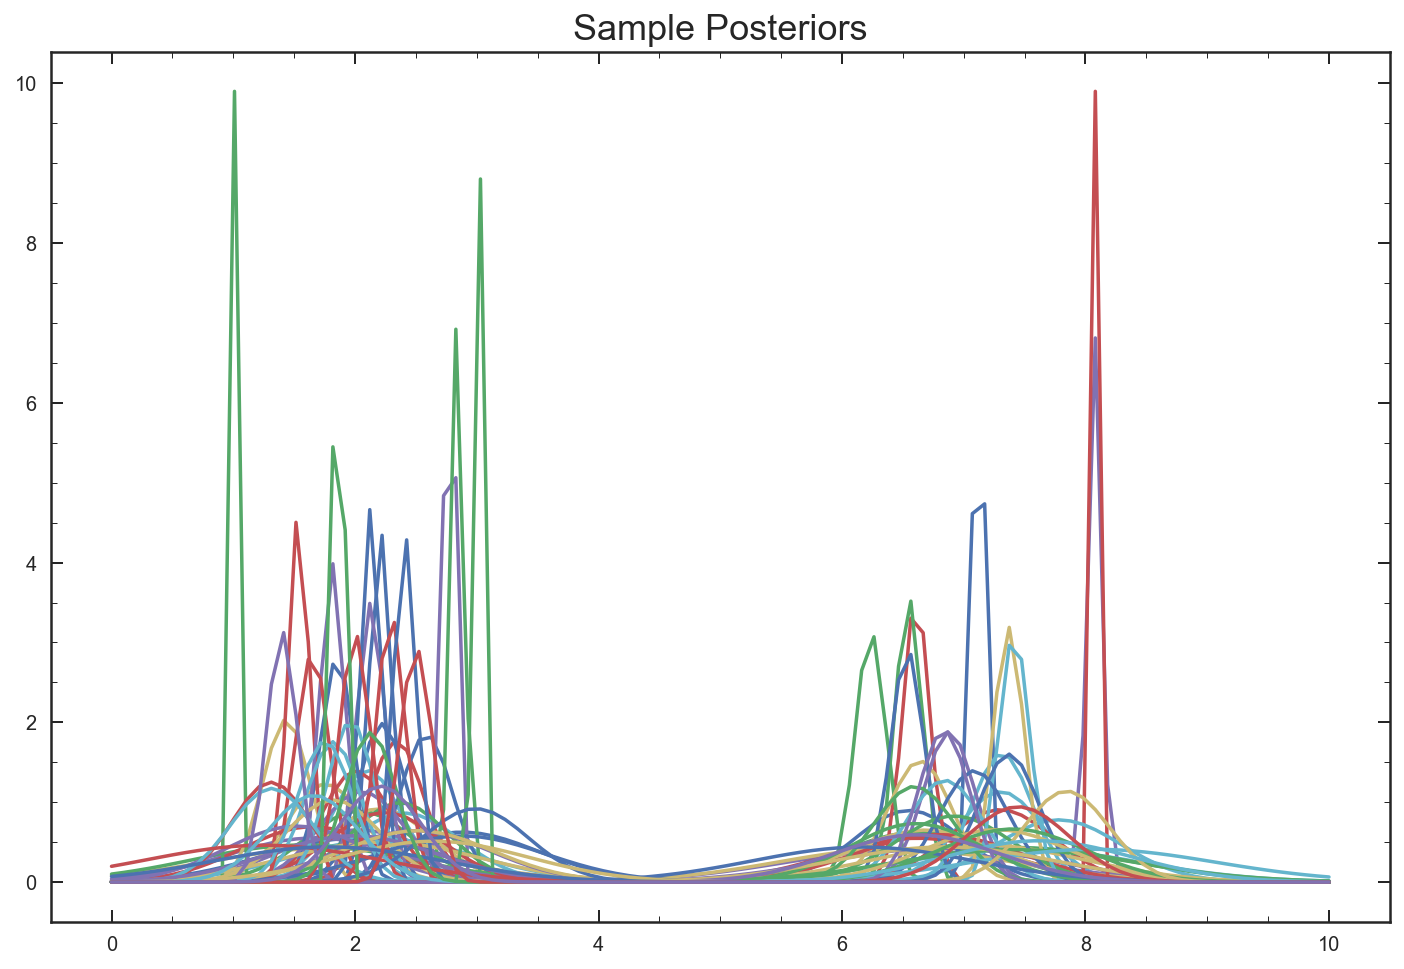

In [72]:
plt.figure(figsize=[12,8])
for i in range(sp_size):
    plt.plot(x,dist_grid[i])
plt.title('Sample Posteriors', fontsize =18)

In [73]:
Pos = Stack_posteriors(dist_grid,x)
iterpos,iterx = Iterative_stacking(dist_grid,x,iterations=20)


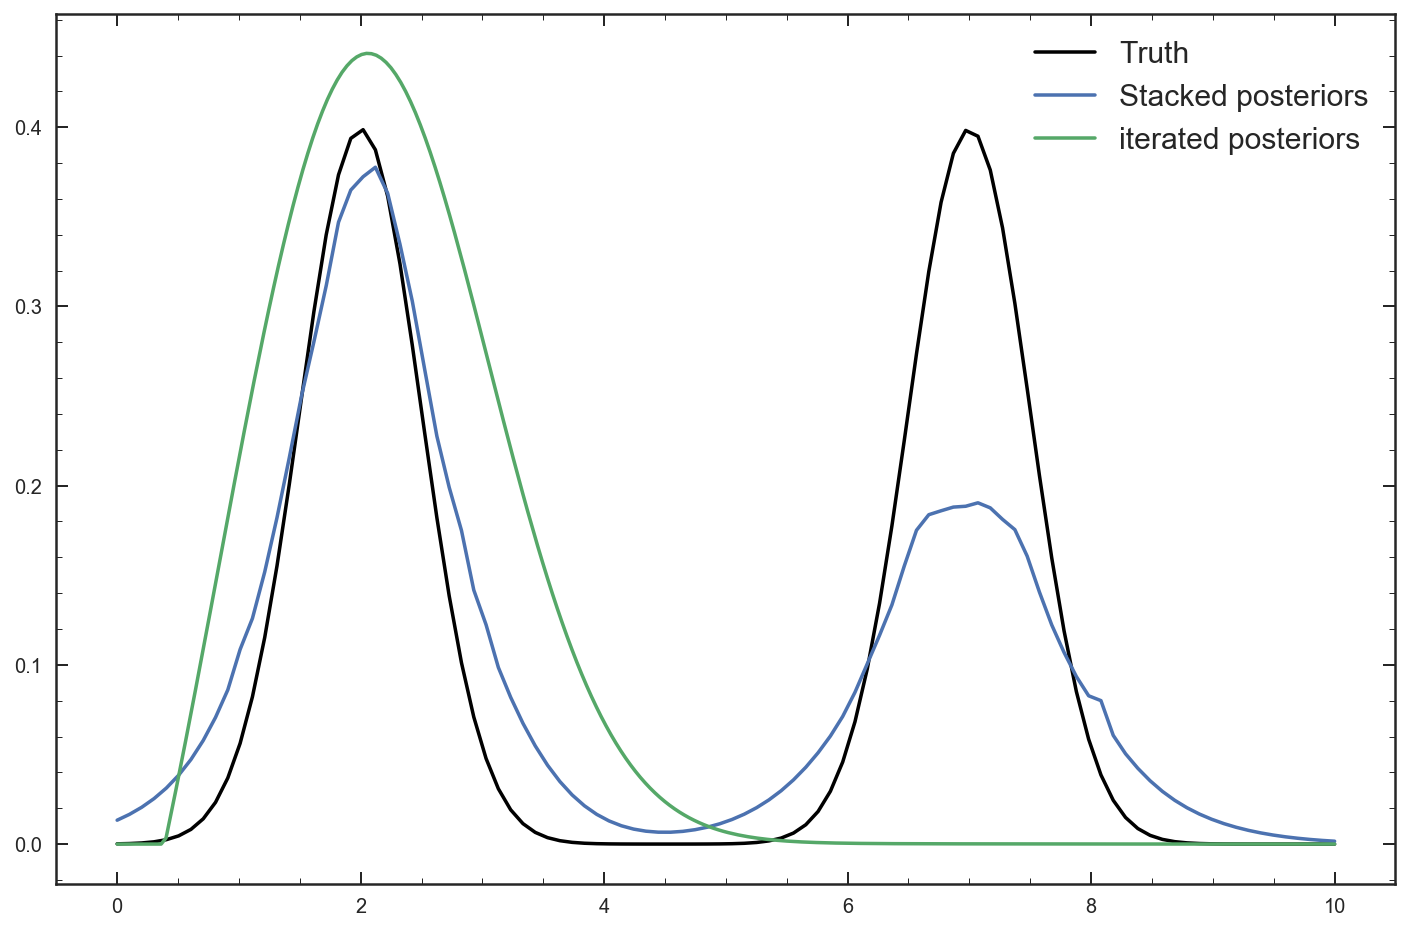

In [74]:
plt.figure(figsize=[12,8])
plt.plot(x,d3,'k',label = 'Truth')
plt.plot(x,Pos,label = 'Stacked posteriors')
plt.plot(iterx,iterpos,label = 'iterated posteriors')
plt.legend(fontsize = 15)